# Oxford Pets Image Segmentation Practice

In [12]:
import os
import numpy as np
from tensorflow import keras 
from keras import layers
import tensorflow as tf 

In [2]:
input_dir = '/home/dfcadmin/data/OxfordPets/images/'
target_dir = '/home/dfcadmin/data/OxfordPets/annotations/trimaps/'
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "||", target_path)

Number of samples: 7390
/home/dfcadmin/data/OxfordPets/images/Abyssinian_1.jpg || /home/dfcadmin/data/OxfordPets/annotations/trimaps/Abyssinian_1.png
/home/dfcadmin/data/OxfordPets/images/Abyssinian_10.jpg || /home/dfcadmin/data/OxfordPets/annotations/trimaps/Abyssinian_10.png
/home/dfcadmin/data/OxfordPets/images/Abyssinian_100.jpg || /home/dfcadmin/data/OxfordPets/annotations/trimaps/Abyssinian_100.png
/home/dfcadmin/data/OxfordPets/images/Abyssinian_101.jpg || /home/dfcadmin/data/OxfordPets/annotations/trimaps/Abyssinian_101.png
/home/dfcadmin/data/OxfordPets/images/Abyssinian_102.jpg || /home/dfcadmin/data/OxfordPets/annotations/trimaps/Abyssinian_102.png
/home/dfcadmin/data/OxfordPets/images/Abyssinian_103.jpg || /home/dfcadmin/data/OxfordPets/annotations/trimaps/Abyssinian_103.png
/home/dfcadmin/data/OxfordPets/images/Abyssinian_104.jpg || /home/dfcadmin/data/OxfordPets/annotations/trimaps/Abyssinian_104.png
/home/dfcadmin/data/OxfordPets/images/Abyssinian_105.jpg || /home/dfcadm

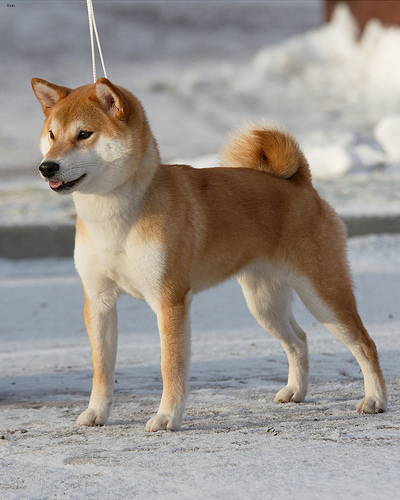

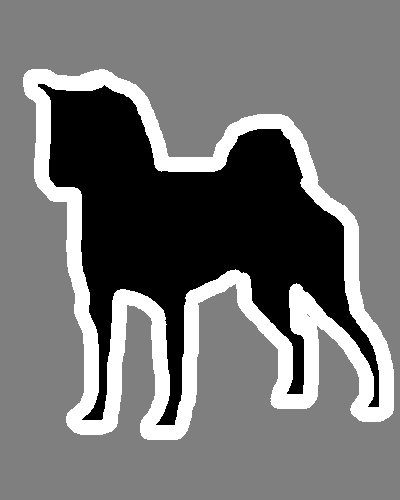

In [51]:
from IPython.display import Image, display
from tensorflow.keras.utils import load_img
from PIL import ImageOps

# display an image
display(Image(filename = input_img_paths[1533]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[1533]))
display(img)


## Prepare Sequence class to load & vectorize batches of data

In [4]:
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y


## Prepare U-Net model

In [39]:
def get_model(img_size,num_classes):
    inputs = layers.Input(shape = img_size + (3,))

    ### [First half of the network: encoder ] ###
    x = layers.Conv2D(32,kernel_size=3,strides=2,padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Activation('relu')(x)

    previous_bloc_activation = x

    for filters in [64,128,256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters,3,padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters,3,padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(2,strides=2,padding='same')(x)

        residual = layers.Conv2D(filters,1,strides=2,padding='same')(previous_bloc_activation)
        # add up residuals
        x = layers.add([x,residual])
        previous_bloc_activation = x  # reset the variable for the next step

      ### [Second half of the network: decoder] ###

    for filters in [256,128,62,32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters,3,padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters,3,padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2,interpolation = 'bicubic')(x)

        residual = layers.UpSampling2D(2,interpolation = 'bicubic')(previous_bloc_activation)
        residual = layers.Conv2D(filters,1,padding = 'same')(residual)

        # add up residuals 

        x = layers.add([x,residual])
        # reset for the next step
        previous_bloc_activation = x  
  
        # add a per-pixel classification layer

        outputs = layers.Conv2D(num_classes,3,activation = 'softmax',padding='same')(x)

    model = keras.Model(inputs,outputs)
    return model


# Free up (possibile) previous sessions

keras.backend.clear_session()

#Build model

model = get_model(img_size,num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Set aside a validation split

In [7]:
import random

# Split image paths to train and test set

validation_samples = 800
random.Random(2).shuffle(input_img_paths)
random.Random(2).shuffle(target_img_paths)
train_input_paths = input_img_paths[:-validation_samples]
train_target_paths = target_img_paths[:-validation_samples]
val_input_paths = input_img_paths[-validation_samples:]
val_target_paths = target_img_paths[-validation_samples:]

# Instantiate data Sequences for each data split

train_generator = OxfordPets(
    batch_size,img_size,train_input_paths,train_target_paths

)

val_generator = OxfordPets(
    batch_size, img_size, val_input_paths,val_target_paths

)

In [20]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy')

# callbacks = [
#     keras.callbacks.ModelCheckpoint('OxfordPets.h5',save_best_only=True)
# ]

model_checkpoint_callback  = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/home/dfcadmin/data/ModelCheckpoints/OxfordPets/oxford1.hdf5',
    save_weights_only = True,
    monitor = 'val_loss',
    save_best_only = True,
    verbose = 1
)

ealy_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.01,
    patience = 5,
    start_from_epoch = 2
)

# The monitor arguments should all be the same
callbacks = [model_checkpoint_callback,ealy_stopping_callback]

# Train the model, then validate it
epochs = 50

history = model.fit(train_generator,epochs = epochs, validation_data = val_generator,callbacks=callbacks,use_multiprocessing=True)



Epoch 1/50


2023-06-09 07:47:48.295279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


205/205 [==============================] - ETA: 0s - loss: 0.1500
Epoch 1: val_loss improved from inf to 0.43177, saving model to /home/dfcadmin/data/ModelCheckpoints/OxfordPets/oxford1.hdf5
205/205 [==============================] - 304s 1s/step - loss: 0.1500 - val_loss: 0.4318
Epoch 2/50
205/205 [==============================] - ETA: 0s - loss: 0.1413
Epoch 2: val_loss did not improve from 0.43177
205/205 [==============================] - 299s 1s/step - loss: 0.1413 - val_loss: 0.4560
Epoch 3/50
205/205 [==============================] - ETA: 0s - loss: 0.1315
Epoch 3: val_loss did not improve from 0.43177
205/205 [==============================] - 303s 1s/step - loss: 0.1315 - val_loss: 0.4578
Epoch 4/50
205/205 [==============================] - ETA: 0s - loss: 0.1309
Epoch 4: val_loss did not improve from 0.43177
205/205 [==============================] - 301s 1s/step - loss: 0.1309 - val_loss: 0.4779
Epoch 5/50
205/205 [==============================] - ETA: 0s - loss: 0.1463


2023-06-09 09:00:51.667283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


25/25 [==============================] - 9s 341ms/step


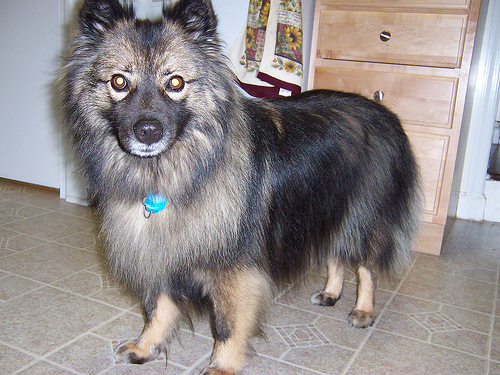

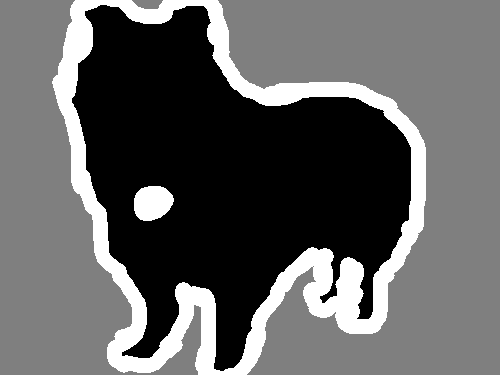

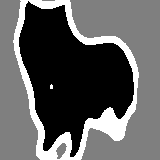

In [38]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_paths, val_target_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 200

# Display input image
display(Image(filename=val_input_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.